# Usupervised Anomaly Detection

### 0. Let's Get Some Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Projet_IA_2023

In [ ]:
!pip install fastai==1.0.61
!pip install jupyter
!pip install matplotlib
!pip install wget
!pip install kornia
!pip install opencv-python


In [4]:
import sys, wget, tarfile, os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def simple_progress_bar(current, total, width=80):
    progress_message = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
    sys.stdout.write("\r" + progress_message)
    sys.stdout.flush()

We will be using in this cola, the Hazelnut Class.

In [6]:
data_path=Path("/content/drive/MyDrive/Projet_IA_2023")
dset='hazelnut'

After our script runs, we can have a look at the structure of our data.

In [ ]:
list((data_path/dset).glob('*'))

We're provided a `train`, `test`, and `ground_truth` (labels) folder, and within the train it looks like we're given 391 examples of non-defective hazelnuts:

In [ ]:
list((data_path/dset/'train').glob('*'))

In [ ]:
im_paths=list((data_path/dset/'train'/'good').glob('*'))
im_paths[:5] #Look at first 5 paths

In [ ]:
len(im_paths) #How many examples do we have?

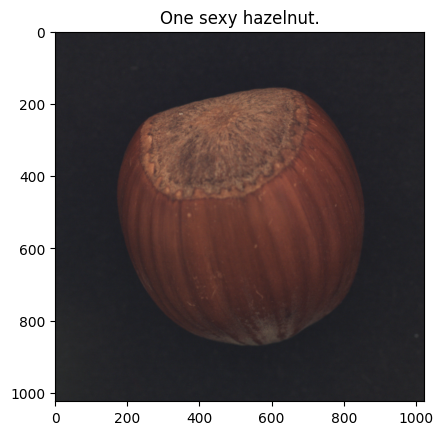

In [12]:
plt.imshow(plt.imread(str(im_paths[0])))
plt.title('Hazelnut_Image');

Our test folder has a bit more going on, and includes examples of a 4 defect classes, and some more good examples to use in testing. We'll set aside our test set for now, and come back to it after training our GAN.

In [ ]:
list((data_path/dset/'test').glob('*'))

### 1. Data Loaders for Training

In [14]:
import kornia
from fastai.vision import *

In [15]:
# Might need/want to supress warnings if your fastai and pytorch versions dont quite agree
import warnings
warnings.filterwarnings('ignore')

One thing I particularly like about fastai is the built in dataloader classes, called DataBunches. Let's create one for our training set. We'll create a a dataloader that will return minibatches of size 128, downsample our images to 64x64 (the resoultion used in the DCGAN paper). Our `databunch` will also take care of data augmentation and normalization.

In [ ]:
import fastai
print(fastai.__version__)

In [17]:
batch_size, im_size, channels = 64, 64, 3
tfms = ([*rand_pad(padding=3, size=im_size, mode='border')], [])
data = ImageList.from_folder(data_path/dset/'train'/'good').split_none() \
                                                                .label_empty() \
                                                                .transform(tfms, size=im_size) \
                                                                .databunch(bs=batch_size) \
                                                                .normalize((0.5, 0.5))

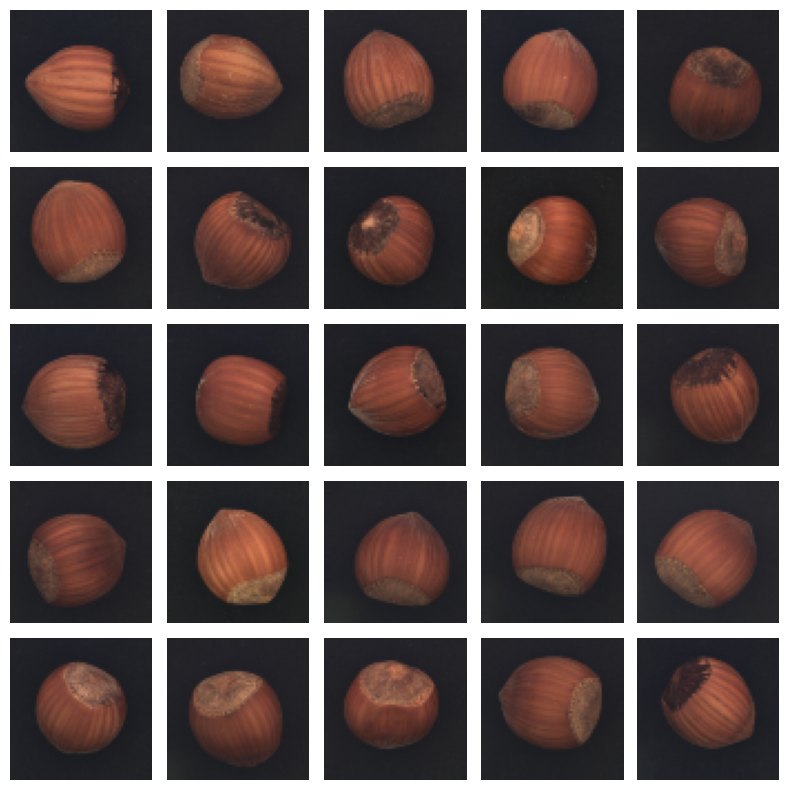

In [18]:
data.show_batch(figsize=(8, 8))

Let's have a quick look at the scale of our data.

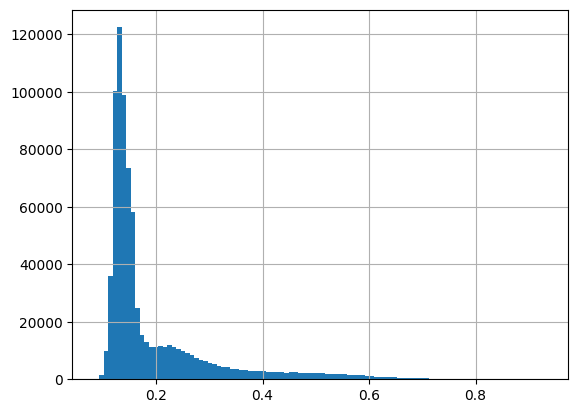

In [19]:
x, y=data.one_batch()
plt.hist(x.numpy().ravel(),100); plt.grid(1)

### 3. Create Models in Pytorch

In [20]:
import torch
import torch.nn as nn

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #Do we have a GPU?
defaults.device = device
print(device)

In [22]:
def conv_trans(ni, nf, ks=4, stride=2, padding=1):
    return nn.Sequential(
        nn.ConvTranspose2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=padding),
        nn.BatchNorm2d(nf),
        nn.ReLU(inplace = True))

In [23]:
G = nn.Sequential(
    conv_trans(100, 1024, ks=4, stride=1, padding=0),
    conv_trans(1024, 512),
    conv_trans(512, 256),
    conv_trans(256, 128),
    nn.ConvTranspose2d(128, channels, 4, stride=2, padding=1),
    nn.Tanh()).to(device)

Let's test our Generator by creating a random vector and passing to the Generator!

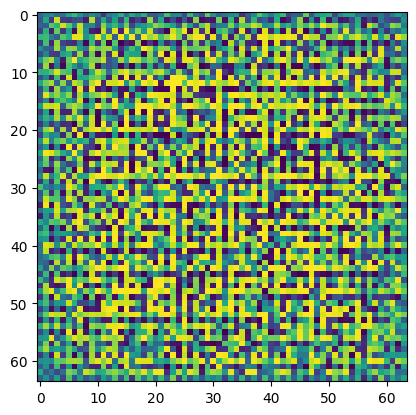

In [25]:
z = torch.randn(1, 100, 1, 1)
fake = G(z.to(device))
plt.imshow(fake[0, 0].cpu().detach().numpy()); plt.grid(0)

Now, let's create the Discriminator.

In [26]:
def conv(ni, nf, ks=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=padding),
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(0.2, inplace = True))

In [27]:
D = nn.Sequential(
    conv(channels, 128),
    conv(128, 256),
    conv(256, 512),
    conv(512, 1024),
    nn.Conv2d(1024, 1, 4, stride=1, padding=0),
    Flatten(),
    nn.Sigmoid()).to(device)

Let's try the Generator and the Discriminator!

In [ ]:
fake=G(z.to(device))
D(fake)

The result we got, is the probability that the fake image is real.

For the training, we'll be passing in both real and fake data into our discriminator.

In [30]:
x,y=data.one_batch()
out=D(x.to(device))
plt.plot(out.detach().cpu()); plt.grid(1)

The outputs we've plotted are the probabilities of being real the discriminator has assigned to each image.

The results are wrong because we didn't train the discriminator yet.

### 4. Training Time

First, we'll choose randomly 25 points in our latent space. At each visualization step, we'll pass these 25 points through our generator, and see how our fake images look. As we train, our random noise should start to be shaped into hazelnuts!

Secondly, we'll plot a histogram of the pixel intensity of our fake images `G(z)` and compare these to our histograms of the pixel intensity values in our real images `x`. As we train, these distributions should look more and more similar.

In [34]:
from torch import optim
from tqdm import tqdm
from IPython import display
import matplotlib.gridspec as gridspec

In [35]:
save_training_viz=True
save_dir=Path('data/exports') #Location to save training visualzations
(save_dir/'viz').mkdir(exist_ok=True, parents=True)
(save_dir/'ckpts').mkdir(exist_ok=True, parents=True)

In [36]:
def show_progress(save=False):
    '''Visualization method to see how were doing'''
    plt.clf(); fig=plt.figure(0, (24, 12)); gs=gridspec.GridSpec(6, 12)
    with torch.no_grad(): fake=G(z_fixed)
    for j in range(30):
        fig.add_subplot(gs[(j//6), j%6])
        plt.imshow((kornia.tensor_to_image(fake[j])+1)/2); plt.axis('off')
    ax=fig.add_subplot(gs[5, :4]); plt.hist(fake.detach().cpu().numpy().ravel(), 100, facecolor='xkcd:crimson')
    ax.get_yaxis().set_ticks([]); plt.xlabel('$G(z)$', fontsize=16); plt.xlim([-1, 1])
    ax=fig.add_subplot(gs[5, 4:7]); plt.hist(x.cpu().numpy().ravel(), 100, facecolor='xkcd:purple')
    ax.get_yaxis().set_ticks([]); plt.xlabel('$x$', fontsize=16)
    fig.add_subplot(gs[:,7:])
    plt.plot(losses[0], color='xkcd:goldenrod', linewidth=2); plt.plot(losses[1], color='xkcd:sea blue', linewidth=2);
    plt.legend(['Discriminator', 'Generator'],loc=1, fontsize=16);
    plt.grid(1); plt.title('Epoch = ' + str(epoch), fontsize=16); plt.ylabel('loss', fontsize=16); plt.xlabel('iteration', fontsize=16);
    display.clear_output(wait=True); display.display(plt.gcf())
    if save: plt.savefig(save_dir/'viz'/(str(count)+'.png'), dpi=150)

Now we'll setup our loss function and optimizers following DCGAN paper:

In [37]:
optD = optim.Adam(D.parameters(), lr=1e-4, betas = (0.5, 0.999))
optG = optim.Adam(G.parameters(), lr=1e-4, betas = (0.5, 0.999))
criterion = nn.BCELoss()

In [ ]:
zero_labels = torch.zeros(batch_size).to(device)
ones_labels = torch.ones(batch_size).to(device)
losses = [[],[]]
epochs, viz_freq, save_freq, count = 100, 100, 500, 0
z_fixed = torch.randn(batch_size, 100, 1, 1).to(device)

for epoch in range(epochs):
    for i, (x,y) in enumerate(tqdm(data.train_dl)):
        #Train Discriminator
        requires_grad(G, False); #Speeds up training a smidge
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        l_fake = criterion(D(G(z)).view(-1), zero_labels)
        l_real = criterion(D(x).view(-1), ones_labels)
        loss = l_fake + l_real
        loss.backward(); losses[0].append(loss.item())
        optD.step(); G.zero_grad(); D.zero_grad();

        #Train Generator
        requires_grad(G, True);
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        loss = criterion(D(G(z)).view(-1), ones_labels)
        loss.backward(); losses[1].append(loss.item())
        optG.step(); G.zero_grad(); D.zero_grad();

        if i%viz_freq==0: show_progress(save_training_viz)
        count+=1
    if (epoch+1)%save_freq==0:
        torch.save(G, save_dir/'ckpts'/('G_epoch_'+str(epoch)+'.pth'))
        torch.save(D, save_dir/'ckpts'/('D_epoch_'+str(epoch)+'.pth'))

In this link, there is a video of a full training that was made by the creator of this method: https://www.youtube.com/embed/33wVaI7NUPw?rel=0&amp;controls=0&amp;showinfo=0

## 5. A Walk Through Latent Space

Something interesting to know is that good images represent a manifold in a higher dimensional latent space of all images. This property can be used to detect anomalies!

Given a new image x, we're going to compute the representation of the image in our GANs latent space, and if our image is on the manifold of good iamges, we're going to call it good. And if it's too far from our manifold, we'll call it an anomaly.

But how can we find the representation of a new image in the latent space?

In [47]:
import cv2

im_path=(data_path/dset/'train'/'good').ls()[1]
im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
im=cv2.resize(im, (64,64))
plt.imshow(im)

We would like to know if how for from the manifold of good images in our Generator's latent space this image lies.

Unfortunately, we can't really compute this directly, but we can try to find the nearest point in our Generator's latent space and measure how far away this image is from that point, giving us an idea of how well this image "fits" with our good images.

We can find this nearest neighbor point using a very similar appraoch to our method for training our network. Specifically, we'll pick a random point in latent space, and using gradient descent, walk through latent space from that point guided by gradient descent.

As a loss function, we can use the l1 loss between our generated image and our "query" image.

$$
\mathcal{L}_R(z_\gamma)=\sum |x-G(z_{\gamma})|
$$

Let's give this a shot. We'll pick a random starting point and train for 1000 iterations to reduce the l1 loss between our query image and generated image.

In [50]:
im_tensor=((kornia.image_to_tensor(im).float()/128)-1).to(device) #Scale image between -1 and +1
z=torch.randn(1, 100, 1, 1, requires_grad=True, device=device) #Random starting point in latent space
opt=optim.Adam([z], lr=2e-2)

In [51]:
losses=[]
for i in tqdm(range(1000)):
    fake=G(z)
    loss=torch.nn.L1Loss()(fake.squeeze(0), im_tensor)
    loss.backward(); opt.step()
    z.grad.zero_(); G.zero_grad()
    losses.append(loss.item())

100%|██████████| 1000/1000 [00:04<00:00, 230.87it/s]


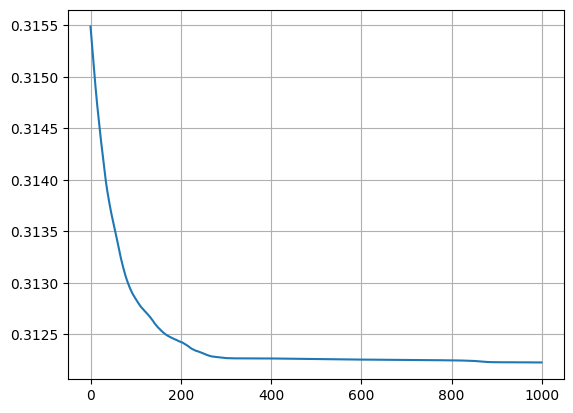

In [52]:
plt.plot(losses); plt.grid(1)

Text(0.5, 1.0, 'Closest Fake Image')

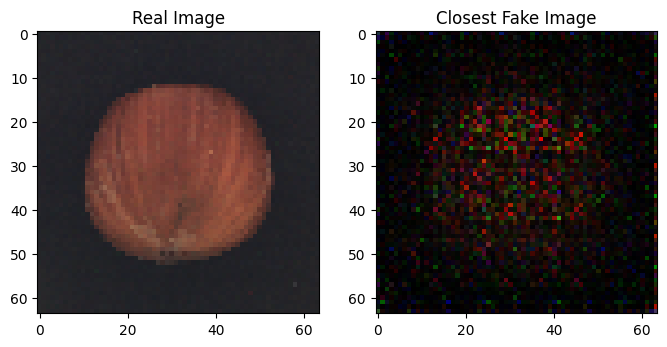

In [53]:
fig=plt.figure(0, (8,4))
fig.add_subplot(1,2,1)
plt.imshow(im); plt.title('Real Image')

fig.add_subplot(1,2,2)
plt.imshow((kornia.tensor_to_image(G(z))+1)/2); plt.title('Closest Fake Image')

The AnoGan authors use one more trick to get better results in finding the closest fake image. As you can imagine, this "optimizing backwards accross our generator" is far from a perfect science. The AnoGAN authors chose to use the discriminator to help the optimization land on a more realistic nearest good image. Specifically, they choose to add a term to the loss function that measures the distance between the discriminator's representation of the real and fake images.

We're going to compare the representation of the real and fake images in the feature space of the discrminator. The idea here is that through the training process the discriminator has learned lots of useful features to measure the perceptual difference between real and fake images. Techniques like this are called **perceptual loss**. The AnoGAN authors again use L1 loss, as shown in the equation below:

$$
\mathcal{L}_D(z_\gamma)=\sum |f(x)-f(G(z_{\gamma}))|
$$

where $f(\cdot)$ represents the intermediate layers of the discriminator. Let's implement this and add it to our approach.

In [54]:
f={} #Precompute feature values for layers
with torch.no_grad():
    for i in range(1, (len(D)-2)): f[i]=D[:i](im_tensor.unsqueeze(0))

Let's create a method that computes the discriminator feature loss loss given a fake image

In [55]:
def get_d_loss(f_x, fake, D):
    loss_d=nn.L1Loss()(f_x[1], D[:1](fake)) #Get loss value from 1st layer of D
    for i in range(2, (len(D)-2)):
        loss_d+=nn.L1Loss()(f_x[i], D[:i](fake)) #And remainig layers of D
    return loss_d

Finally, we need to balance our two loss terms (or reconsruction loss and discrminator loss). The anogan authors capture this in this equation:

$$
\mathcal{L}(z_\gamma) = (1-\lambda) \cdot \mathcal{L}_R(z_\gamma) + \lambda \cdot \mathcal{L}_D(z_\gamma).
$$

Where $\mathcal{L}(z_\gamma)$ is our overall loss function value, and $\lambda$ conrols the balance between our generator and discriminator loss. Let's put all of this together into a nice method we'll call `walk_latent_space`. Using our new loss function, this method will seek to find the z that minimizes our loss.

In [56]:
def walk_latent_space(G, D, im_tensor, n_iter=1500, lambd=0.1, lr=2e-2, device='cuda'):
    f_x={} #Precompute feature values all layers of D
    with torch.no_grad():
        for i in range(1, (len(D)-2)): f_x[i]=D[:i](im_tensor.unsqueeze(0))

    z=torch.randn(1, 100, 1, 1, requires_grad=True, device=device) #random starting point for walk
    opt=optim.Adam([z], lr=lr)

    losses=[]
    for i in tqdm(range(n_iter)):
        fake=G(z) #Get fake image
        loss_r=torch.nn.L1Loss()(fake.squeeze(0), im_tensor) #Residual loss
        loss_d=get_d_loss(f_x, fake, D) #Discrimintator loss
        loss=(1-lambd)*loss_r+lambd*loss_d #Total loss

        loss.backward(); opt.step()
        z.grad.zero_(); G.zero_grad(); D.zero_grad();
        losses.append(loss.item())
    return {'z':z, 'loss':loss.item(), 'loss_r':loss_r.item(), 'loss_d':loss_d.item(), 'losses':losses}

In [57]:
im_path=(data_path/dset/'train'/'good').ls()[1]
im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
im=cv2.resize(im, (64,64))
im_tensor=((kornia.image_to_tensor(im).float()/128)-1).to(device)
res=walk_latent_space(G, D, im_tensor, n_iter=1500, lambd=0.1, lr=2e-2, device='cuda')

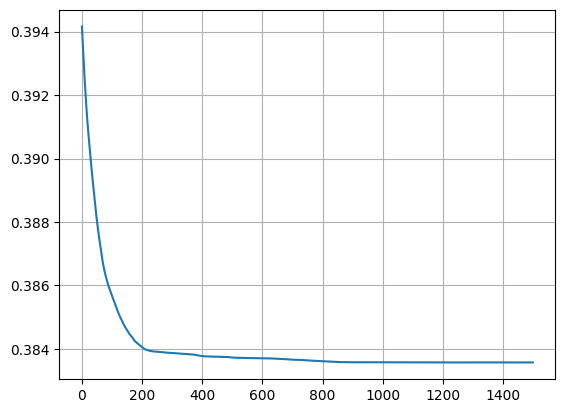

In [59]:
# Let's plot the loss.
plt.plot(res['losses']); plt.grid(1)

Let's have a look at the trade-off between the reconsruction loss and the discriminator loss.

In [60]:
res['loss'], res['loss_d'], res['loss_r']

(0.38357409834861755, 1.018933892250061, 0.3129785656929016)

Finally, let's see the result.

Text(0.5, 1.0, 'Closest Fake Image')

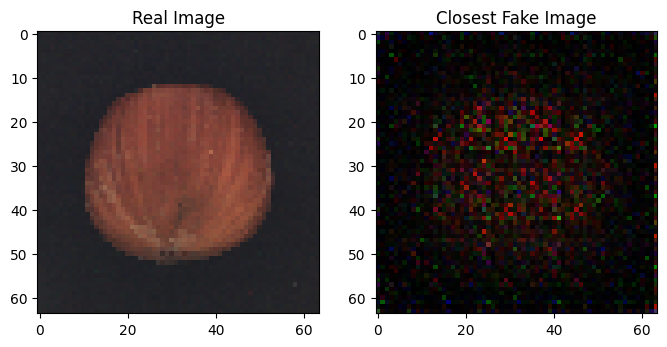

In [61]:
fig=plt.figure(0, (8,4))
fig.add_subplot(1,2,1)
plt.imshow(im); plt.title('Real Image')

fig.add_subplot(1,2,2)
plt.imshow((kornia.tensor_to_image(G(res['z']))+1)/2); plt.title('Closest Fake Image')

## 6. Finding Anomalies

Now, we finally have all the pieces we need to find anomalies using our GAN. To see how this works, let's grab an image with some anomalies.

In [64]:
im_path=Path('/content/drive/MyDrive/Projet_IA_2023/hazelnut/test/print/016.png')
im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
im=cv2.resize(im, (64,64))

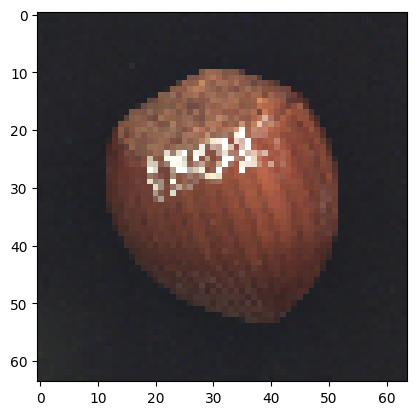

In [65]:
plt.imshow(im)

As you can see, our image has "print" anomolies, where a mark has been printed on our poor hazelnut! Now, a big part of the anogan idea here is that anoalous images like this shouldn't really exists in the latent space of our Generator, since we only trained it on good images. So when we try to reconsturct our anamolous image, the reconstruction should fail in a very useful way. Ideally, the reconstruction should yeild "closest good image" - and this closest image is going to help us find anomalies! Let's try it.

In [66]:
im_tensor=((kornia.image_to_tensor(im).float()/128)-1).to(device)
res=walk_latent_space(G, D, im_tensor, n_iter=1500, lambd=0.1, lr=2e-2, device='cuda')

100%|██████████| 1500/1500 [00:14<00:00, 104.32it/s]


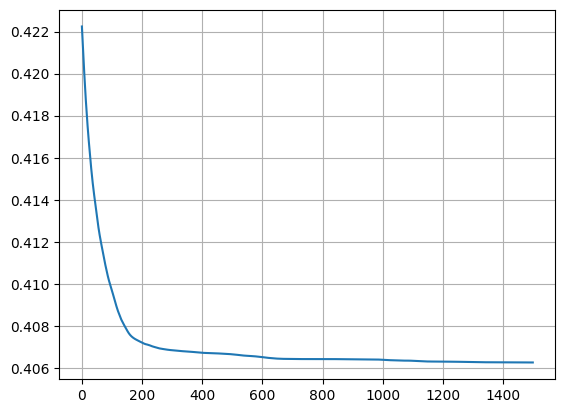

In [67]:
plt.plot(res['losses']); plt.grid(1)

Alright, let's have a look at our reconstructed image:

Text(0.5, 1.0, 'Closest Fake Image')

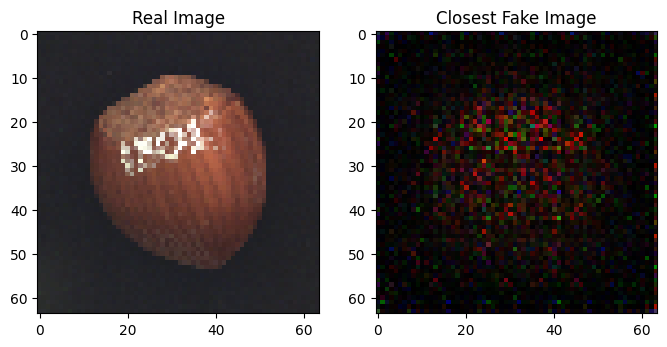

In [68]:
fig=plt.figure(0, (8,4))
fig.add_subplot(1,2,1)
plt.imshow(im); plt.title('Real Image')

fig.add_subplot(1,2,2)
plt.imshow((kornia.tensor_to_image(G(res['z']))+1)/2); plt.title('Closest Fake Image')

And as you can see, our reconstuction isn't great. Happily, this is exactly what we wanted! We shouldn't be able to reconstruct anomolous images. Now, if we can measure how poor our reconsruction is, we can use this metric to measure how anamolous our images are - cool, rigtht? And happily, as we dicussed above, we already have a couple metrics that capture the quality of our reconstruction, our reconsruction loss $\mathcal{L}_R(z_\gamma)$ and our discriminator loss $\mathcal{L}_D(z_\gamma)$. There idea here is that our anomolous images should have a higher reconsruction and discrimator loss. We explore this idea rigorously below. But first, let's discuss one more neat trick. Not only can we use GANs to identify anomolous images, we can also use GANs to identify anomolous *regions* in images. There idea here is that we can compute a "residual image" - the difference between our original and reconstructed image - and areas of the residual images with large values *should* correspond to anomalous regions, since the original and reconstructed image are maxiamlly different in these regions. Let's try it.

In [69]:
xr=np.abs((im.astype('float')/255)-(kornia.tensor_to_image(G(z))+1)/2) #Residual image

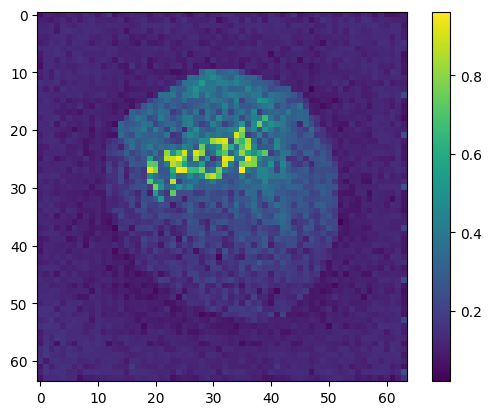

In [70]:
plt.imshow(np.mean(xr, axis=2))
plt.colorbar()

See the anomolous regions glowing? Pretty cool, right? We can take this a step further and threshold our redidual image to identify anomolous pixels:

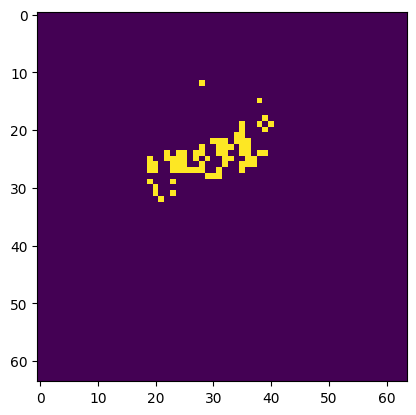

In [71]:
thresh=0.5
plt.imshow(np.mean(xr, axis=2)>thresh)

Finally, let's put it all together;

Text(0.5, 1.0, 'Anomalous Region')

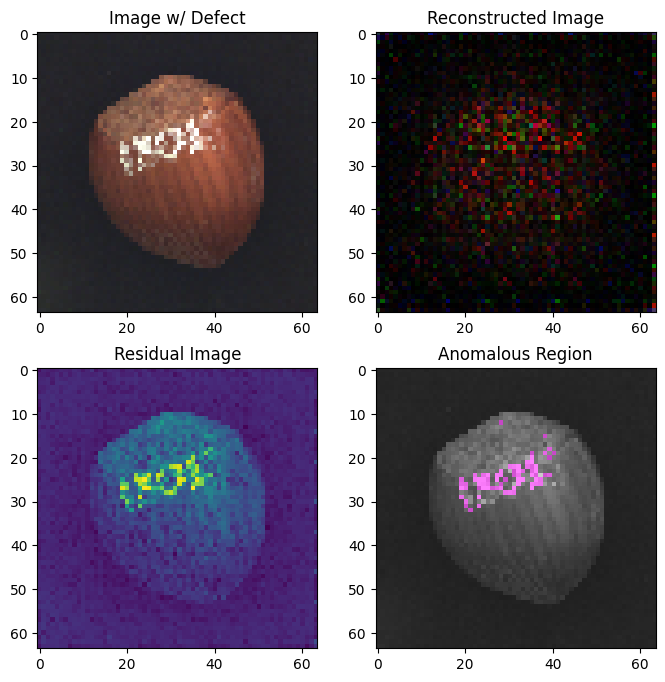

In [72]:
im_mask=np.zeros_like(im)
for i in range(3): im_mask[:,:,i]=np.mean(im, axis=2)
im_mask[np.mean(xr, axis=2)>thresh]=im_mask[np.mean(xr, axis=2)>thresh]//2+np.array([255,0,255])//2

fig=plt.figure(0, (8,8))
fig.add_subplot(2,2,1); plt.imshow(im); plt.title('Image w/ Defect')
fig.add_subplot(2,2,2); plt.imshow((kornia.tensor_to_image(G(res['z']))+1)/2); plt.title('Reconstructed Image')
fig.add_subplot(2,2,3); plt.imshow(np.mean(xr, axis=2)); plt.title('Residual Image')
fig.add_subplot(2,2,4); plt.imshow(im_mask); plt.title('Anomalous Region')

Alright, back to that idea of using our reconstruction and discriminator loss to identify anomolous images. Let's loop over all of our test iamges, and for each we'll created a reconstructed image, and compute our reconsruction and discriminator loss for each image. We'll then visualize these results to see if we can use these metrics to find anomolous images.

In [ ]:
params={'n_iter':1500, 'lambd':0.1, 'lr':2e-2}
all_res=[]
im_paths=[p for p in (data_path/dset/'test').glob('*/*.png')]
for im_path in im_paths:
    im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
    im=cv2.resize(im, (64,64))

    im_tensor=((kornia.image_to_tensor(im).float()/128)-1).to(device)
    res=walk_latent_space(G, D, im_tensor, **params, device=device)

    res['im_fake']=(kornia.tensor_to_image(G(res['z']))+1)/2 #Scaled between 0 and 1
    res['im_path']=im_path
    res['label']=im_path.parent.name
    all_res.append(res)

 25%|██▍       | 370/1500 [00:05<00:15, 71.60it/s]

In [ ]:
labels=np.unique([res['label'] for res in all_res])
cm={l:i for i,l in enumerate(labels)}

my_cmap={0:'r', 1:'b', 2:'g', 3:'c', 4:'m', 5:'y'}
my_markers={0:'o', 1:'x', 2:'^', 3:'<', 4:'>', 5:'*'}

In [ ]:
fig=plt.figure(0, (8,8))
handles={}
for res in all_res:
    handles[res['label']]=plt.scatter(res['loss_d'], res['loss_r'], c=my_cmap[cm[res['label']]], marker=my_markers[cm[res['label']]])
plt.legend(handles=handles.values(), labels=handles.keys(), fontsize=14); plt.grid(1)
plt.xlabel('Discriminator Loss', fontsize=14)
plt.ylabel('Residual Loss', fontsize=14)

Alright, this plot is really interesting! To be honest it didn't come at quite as cleanly as I expected, but this happens fairly frequently in ML, especially when experimenting with new types of algorithms like GANs. Since our generator should find it more difficult to reproduce anomlous images, we *should* see a higher reconstruction loss for our anomolous images, relative to our good images. As you can see, this isn't really true, with our good images having medium to high reconsruction losses. However, we do see a pretty reasonable/nice pattern with our discriminator - anomalous images tend to have higher discriminator losses. We can use this to create our very own anomalous image detector. We'll create a simple method that takes in an image, computed our reconsruction, and returns true if our discrimnator and reconsruction loss exceed set thresholds. Not you could do something more sophisticated here, such as multivariate logistic regression (or even another neural network!) to classify anomolous images in the space of our discriminator and residual loss - this may lead to overfitting and we would likeley want to introduce a proper test set, but could be interesting to experiment with.

In [ ]:
def anomaly_detector(im, G, D, d_loss_thresh, r_loss_thresh):
    '''Decides if image im is anomalous'''
    im_tensor=((kornia.image_to_tensor(im).float()/128)-1).to(device)
    res=walk_latent_space(G, D, im_tensor, n_iter=1500, lambd=0.1, lr=2e-2, device='cuda')
    if res['loss_d']>d_loss_thresh or res['loss_r']>r_loss_thresh: return True
    else: return False

Ok, let's test our our new function! We'll choose a `d_loss_thresh` of 1.3 (just based on eye balling plot), and a `r_loss_thresh` value of 0.21. Note that our redisual loss threshold isn't really doing much here, but may be useful for other types of images or other GAN weights. Let's measure the accuracy of our anomaly detector:

In [ ]:
im_path=data_path/dset/'test'/'good'/'001.png' #Test on good example - should return False
im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
im=cv2.resize(im, (64,64))
predicted_anomaly=anomaly_detector(im, G, D, d_loss_thresh=1.3, r_loss_thresh=0.21)
print(predicted_anomaly)

In [ ]:
im_path=data_path/dset/'test'/'crack'/'001.png' #Test on defect - should return True
im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
im=cv2.resize(im, (64,64))
predicted_anomaly=anomaly_detector(im, G, D, d_loss_thresh=1.3, r_loss_thresh=0.21)
print(predicted_anomaly)

Alright, 2 for 2! Now, let's see what our accuracy is accross all our data.

In [ ]:
num_correct=0; total=0 #Measure accuracy on good test examples
for im_path in (data_path/dset/'test'/'good').glob('*.png'):
    im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
    im=cv2.resize(im, (64,64))
    predicted_anomaly=anomaly_detector(im, G, D, d_loss_thresh=1.3, r_loss_thresh=0.21)
    if not predicted_anomaly: num_correct+=1
    total+=1
    print(im_path, predicted_anomaly)

In [ ]:
num_correct/total

In [ ]:
num_correct=0; total=0 #Measure accuracy on defective test examples
for im_path in (data_path/dset/'test').glob('*/*'):
    if 'good' in str(im_path): continue
    im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
    im=cv2.resize(im, (64,64))
    predicted_anomaly=anomaly_detector(im, G, D, d_loss_thresh=1.3, r_loss_thresh=0.21)
    if predicted_anomaly: num_correct+=1
    total+=1
    print(im_path, predicted_anomaly)

In [ ]:
num_correct/total

For comparison, the MVTec AD paper sites an accruacy on hazelnuts using AnoGAN of 0.83 for the good examples, and 0.16 for the anamolous examples. We appear to be performing a bit better with an accuracy on good examples of around 98% and accuracy on anomalous examples of 68%. There are some differences between decisioning criteria, and our ad-hoc threshold based decisioning may not generalize terribly well, this would require more experimentation - but not a bad start!

Finally, if you would like to wrap up (and maybe deploy!) our anomaly detector, check out the `anomaly_detector.py` script, you can run this script from the terminal like this:

```
python anomaly_detector.py --path_to_image PATH_TO_IMAGE --weights_dir PATH_TO_WEIGHTS --d_loss_thresh=1.3 --r_loss_thresh 0.21
```